In [39]:
# Import necessary libraries
import pandas as pd                 #manipulation and analysis
import numpy as np                  #numerical computing
import matplotlib.pyplot as plt     # For creating visualizations
import seaborn as sns               
from sklearn.feature_extraction.text import TfidfVectorizer  #text vectorization
from sklearn.model_selection import train_test_split    #splitting data into train and test sets
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score  #model evaluation
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV        #hyperparameter tuning
from sklearn.naive_bayes import MultinomialNB           #Naive Bayes classifier
from sklearn.linear_model import LogisticRegression     #Logistic Regression classifier
from sklearn.ensemble import RandomForestClassifier    #Random Forest classifier
from sklearn.ensemble import VotingClassifier          #Voting Classifier
import re # for regular expression
import string # for string operations
import nltk
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english')) # Creating a set of English stopwords for text filtering

##  Loading the data

In [3]:
tweets = pd.read_csv('train.csv')
train = tweets.copy()
test = pd.read_csv('test.csv')

In [4]:
train.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


In [5]:
train.shape

(6525, 3)

Sports      3325
Politics    3200
Name: Label, dtype: int64


<AxesSubplot:xlabel='Label', ylabel='count'>

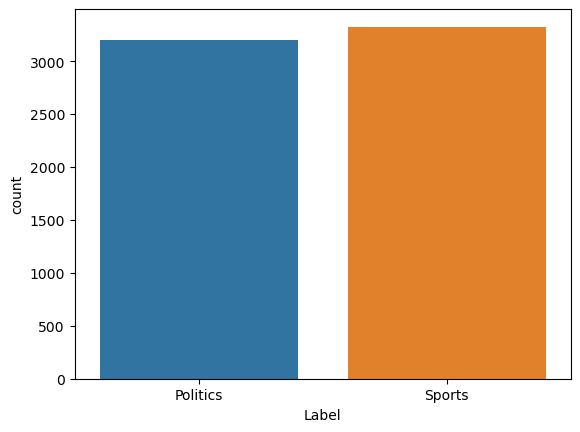

In [6]:
print(train['Label'].value_counts())
sns.countplot(data=train, x="Label")

The dataset is relatively balanced

In [7]:
print(train.isna().sum())

TweetId      0
Label        0
TweetText    0
dtype: int64


Great, No missing values

## **Meta Features**
Understanding the distributions of meta-features in our dataset can be informative for selecting and tuning machine learning models.
. The meta features used for the analysis are;
* `word_count` number of words in text
* `unique_word_count` number of unique words in text
* `stop_word_count` number of stop words in text
* `url_count` number of urls in text
* `mean_word_length` average character count in words
* `char_count` number of characters in text
* `punctuation_count` number of punctuations in text
* `hashtag_count` number of hashtags (**#**) in text
* `mention_count` number of mentions (**@**) in text

In [8]:
def extract_text_features(df):
    df['word_count'] = df['TweetText'].apply(lambda x: len(str(x).split()))
    df['unique_word_count'] = df['TweetText'].apply(lambda x: len(set(str(x).split())))
    df['stop_word_count'] = df['TweetText'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    df['url_count'] = df['TweetText'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
    df['mean_word_length'] = df['TweetText'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df['char_count'] = df['TweetText'].apply(lambda x: len(str(x)))
    df['punctuation_count'] = df['TweetText'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df['hashtag_count'] = df['TweetText'].apply(lambda x: len([c for c in str(x) if c == '#']))
    df['mention_count'] = df['TweetText'].apply(lambda x: len([c for c in str(x) if c == '@']))
    return df

# Applying the function to the training and testing dataframes
train = extract_text_features(train)
test = extract_text_features(test)

In [9]:
train.head(5)

,TweetId,Label,TweetText,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...,21,19,11,0,5.000000,125,9,1,2
1,304834304222064640,Politics,'@rraina1481 I fear so',4,4,1,0,5.000000,23,3,0,1
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...,14,14,5,1,6.357143,102,8,1,0
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...,12,12,2,0,9.166667,121,10,3,3
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...,10,10,3,0,5.300000,62,7,0,1


## **Data Cleaning**

In [10]:
def clean_text(text):
    # Convert text to lowercase
    text = str(text).lower()
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove text within square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove emojis and other non-ASCII characters
    text = re.sub("[" 
                   u"\U0001F600-\U0001F64F"  
                   u"\U0001F300-\U0001F5FF"  
                   u"\U0001F680-\U0001F6FF"  
                   u"\U0001F1E0-\U0001F1FF"  
                   u"\U00002702-\U000027B0"  
                   u"\U000024C2-\U0001F251"  
                   "]+", "", text)
    
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Tokenize text
    words = text.split()
    # Remove stop words
    words = [word for word in words if word not in STOPWORDS]
    # Join words back into a single string
    text = ' '.join(words)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

#CLeaning training and testing dataframes
tweets['TextClean'] = tweets['TweetText'].apply(clean_text)
test['TextClean'] = test['TweetText'].apply(clean_text)

In [11]:
tweets['TextClean'].head()

0    seckerry value statedept usaid measured dollar...
1                                          rraina fear
2    watch video highlights wwc final australia wes...
3    rt chelscanlan nitro circus albertpark theymak...
4         cricketfox always good thing thanks feedback
Name: TextClean, dtype: object

## **Features Extraction**

In [12]:
# Create the feature matrix using TfidfVectorizer and the target vector
vectorizer = TfidfVectorizer()
vectorizer.fit(tweets['TweetText'])
X = vectorizer.transform(tweets['TweetText']).toarray()
y = tweets['Label']

## Model Training

### 1. MultinomialNB

In [13]:
# Splitting our data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# let's have an insight about our algorithm's behavior with an initial hyperparameter value
model = MultinomialNB(alpha=2)
model.fit(X_train, y_train)

MultinomialNB(alpha=2)

In [15]:
y_predict_train = model.predict(X_train)
y_predict_test = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_predict_train)
test_accuracy = accuracy_score(y_test, y_predict_test)


print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Train Accuracy: 0.98
Test Accuracy: 0.95


Time for finding the best hyperparameters for our model

In [18]:
# Define a grid of hyperparameters to search through
param_grid = {
    'alpha': [0.1, 0.5, 1, 2, 5]
}

grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
# Save the best estimator
model = grid_search.best_estimator_

In [44]:
print("Best hyperparameter value is : ",best_params['alpha'])

Best hyperparameter value is :  0.1


In [19]:
y_predict_train = model.predict(X_train)
y_predict_test = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_predict_train)
test_accuracy = accuracy_score(y_test, y_predict_test)


print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Train Accuracy: 1.00
Test Accuracy: 0.97


In [21]:
# Classification Report
print("Classification Report for Test Set:")
print(classification_report(y_test, y_predict_test))

# Confusion Matrix
print("Confusion Matrix for Test Set:")
print(confusion_matrix(y_test, y_predict_test))

Classification Report for Test Set:
              precision    recall  f1-score   support

    Politics       0.97      0.97      0.97       638
      Sports       0.97      0.97      0.97       667

    accuracy                           0.97      1305
   macro avg       0.97      0.97      0.97      1305
weighted avg       0.97      0.97      0.97      1305

Confusion Matrix for Test Set:
[[618  20]
 [ 17 650]]


<Figure size 800x600 with 0 Axes>

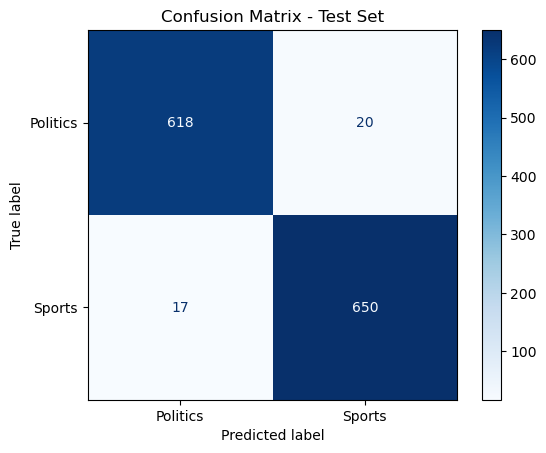

In [27]:
# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.show()

In [28]:
# Same process , let's define hyperparameters to tune
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2']  # Penalty term
}

# Create a Logistic Regression classifier
logistic_regression = LogisticRegression()

# Grid search with cross-validation
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Best accuracy score
print("Best accuracy score:", grid_search.best_score_)

# Get the best model
model2 = grid_search.best_estimator_

Best hyperparameters: {'C': 100, 'penalty': 'l2'}
Best accuracy score: 0.9480842911877394


In [29]:
# Evaluate the model on the test set
test_accuracy = model2.score(X_test, y_test)
print("Test accuracy of the best model:", test_accuracy)

Test accuracy of the best model: 0.960919540229885


In [30]:
y_predict_train = model2.predict(X_train)
y_predict_test = model2.predict(X_test)

train_accuracy = accuracy_score(y_train, y_predict_train)
test_accuracy = accuracy_score(y_test, y_predict_test)


print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Train Accuracy: 1.00
Test Accuracy: 0.96


In [31]:
# Classification Report
print("Classification Report for Test Set:")
print(classification_report(y_test, y_predict_test))

# Confusion Matrix
print("Confusion Matrix for Test Set:")
print(confusion_matrix(y_test, y_predict_test))

Classification Report for Test Set:
              precision    recall  f1-score   support

    Politics       0.97      0.95      0.96       638
      Sports       0.95      0.97      0.96       667

    accuracy                           0.96      1305
   macro avg       0.96      0.96      0.96      1305
weighted avg       0.96      0.96      0.96      1305

Confusion Matrix for Test Set:
[[604  34]
 [ 17 650]]


<Figure size 800x600 with 0 Axes>

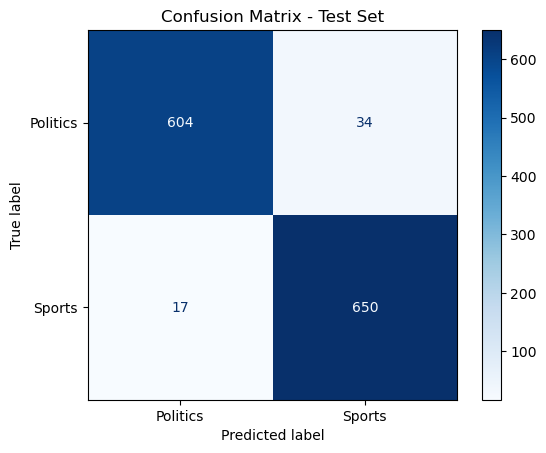

In [32]:
# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
plot_confusion_matrix(model2, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.show()

Let's try to exploit the power of ensemble learning by employing a Voting Classifier to enhance the performance  our model.

In [36]:
# Define the ensemble model with the trained models
final_model = VotingClassifier(estimators=[('multinomial', model), ('logistic_regression', model2)], voting='hard')

# Fit the ensemble model
final_model.fit(X_train, y_train)

# Calculate accuracy scores
train_score = final_model.score(X_train, y_train)
test_score = final_model.score(X_test, y_test)
train_accuracy = accuracy_score(y_train, y_predict_train)
test_accuracy = accuracy_score(y_test, y_predict_test)

# Print accuracy scores
print("Ensemble Model:")
print(f"Train Score: {train_accuracy:.2f}")
print(f"Test Score: {test_accuracy:.2f}")

Ensemble Model:
Train Score: 1.00
Test Score: 0.96
